In [9]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pickle
from statsmodels.nonparametric import smoothers_lowess as lowess

from core import qlearning as q
from core import prices as pr


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Variation du $\beta$:

Intuition : 
- Plus le $\epsilon$ tend vite vers 0 ($\beta$ grand), plus on optimise, plus les profits vont être ceux de Nash
- Il y aura une valeur de $\beta$ moyenne pour lequelle il y aura collusion 
- Si $\epsilon$ trop proche de 1, tend vers 0 trop lentement ($\beta$ très petit) il n'y aura pas de stratégie (tout le temps action aléatoire)


In [11]:
# Path to the pickle file
pickle_file_path = '/Volumes/OS-Data/Suzie_data/RLandPricing/data/data_epsilon.pkl'

# Open the file in binary read mode
with open(pickle_file_path, 'rb') as file:
    aggregated_agents = pickle.load(file)

# Now, "aggregated_agents" contains the object saved in the pickle file
print(aggregated_agents)

[array([[[0.30253787, 0.25121216],
        [0.17385306, 0.39386148],
        [0.3426892 , 0.30793852],
        ...,
        [0.1964421 , 0.24589853],
        [0.12374889, 0.35742997],
        [0.21612698, 0.4126143 ]],

       [[0.39907843, 0.25684852],
        [0.36248322, 0.29202387],
        [0.36473437, 0.1127603 ],
        ...,
        [0.26890315, 0.22738846],
        [0.21894718, 0.21894718],
        [0.15166079, 0.36351401]],

       [[0.21437757, 0.25068303],
        [0.39084318, 0.25377885],
        [0.30318062, 0.23089762],
        ...,
        [0.24643534, 0.26868653],
        [0.21608923, 0.35284496],
        [0.13925932, 0.37308941]],

       ...,

       [[0.23844847, 0.41563149],
        [0.10230197, 0.37122499],
        [0.38529321, 0.1559866 ],
        ...,
        [0.24643534, 0.26868653],
        [0.22268881, 0.36946922],
        [0.15166079, 0.36351401]],

       [[0.28623713, 0.23970425],
        [0.28272627, 0.31197786],
        [0.3221293 , 0.3221293 ],
        

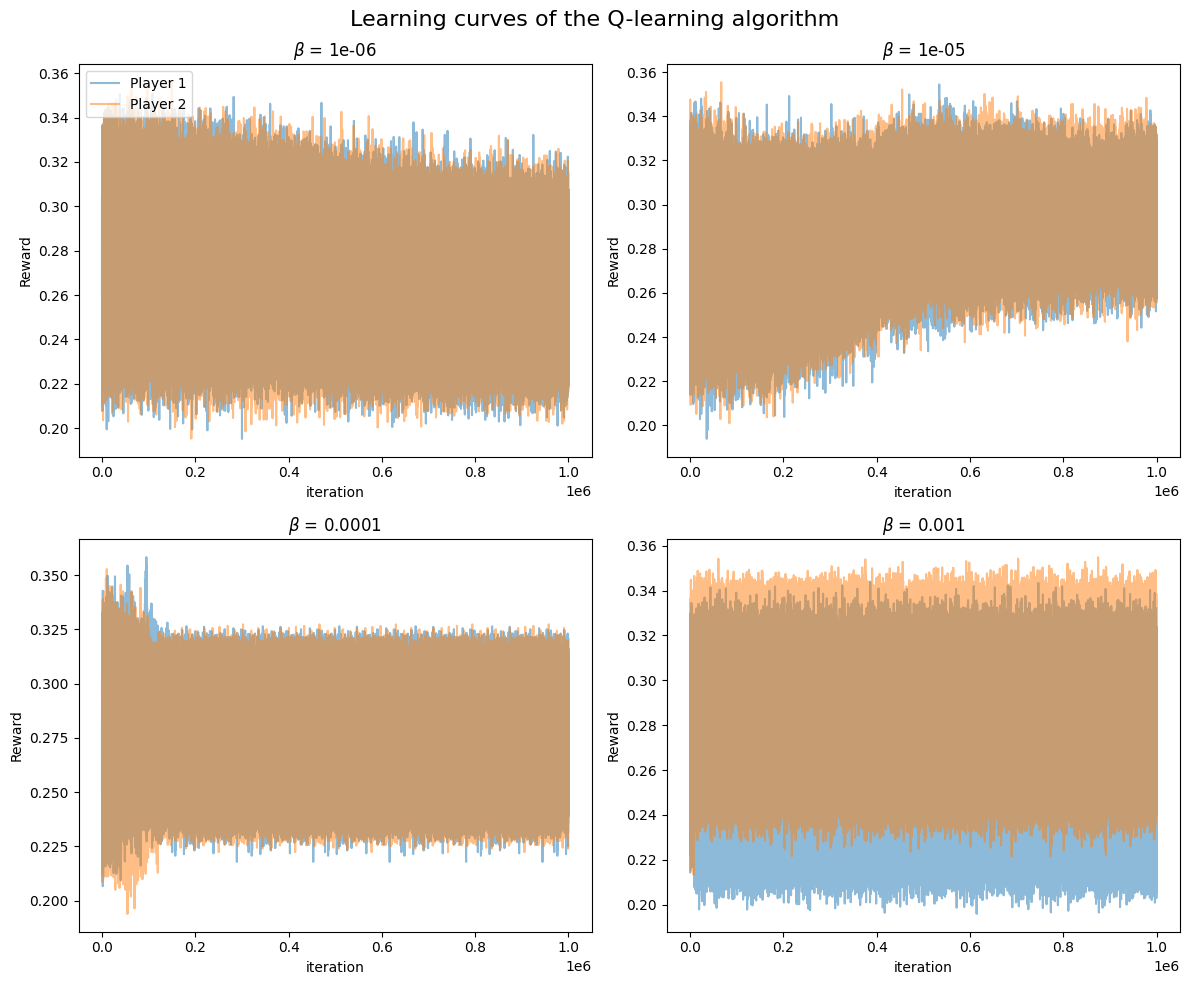

In [12]:
agg = np.array(aggregated_agents).mean(axis=1)
num_players = 2
num_graphs = len(agg)
beta = [10**(-6),10**(-5),10**(-4),10**(-3)]

# Create a figure with a 2x2 grid of subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

# Flatten the axes array to iterate over the subplots
axes = axes.flatten()

# Loop to iterate through the periods and subplots
for graph_num in range(num_graphs):
    ax = axes[graph_num]
    num_players = len(agg[graph_num][0])
    # Plot curves for each player in the subplot
    for player in range(num_players):
        ax.plot(agg[graph_num][:, player], alpha=0.5, label=f'Player {player + 1}')
    
    # Set the title of the subplot with the corresponding period
    ax.set_title(f'$\\beta$ = {beta[graph_num]}')
    
    # Set the labels of the subplot
    ax.set_xlabel('iteration')
    ax.set_ylabel('Reward')

    # Add a legend to the first subplot
    if graph_num == 0:
        ax.legend(loc='upper left') 

# Remove any unused subplots
if num_graphs < 4:
    for i in range(num_graphs, 4):
        fig.delaxes(axes[i])

# Create a legend in the first subplot
if graph_num == 0:
         # Legend in the top-left corner
        ax.spines['top'].set_visible(True)  # Show top spine
        ax.spines['right'].set_visible(True)  # Show right spine
        ax.spines['bottom'].set_visible(True)  # Show bottom spine
        ax.spines['left'].set_visible(True)  # Show left spine

# Get the legend handles and labels from the first subplot
handles, labels = axes[0].get_legend_handles_labels()


fig.suptitle('Learning curves of the Q-learning algorithm', fontsize=16)

# Adjust the spacing between subplots
plt.tight_layout()

# Display the figure
plt.show()

[0.67302005 0.09357431 0.5444705  0.5492962  0.44415185 0.5646083
 0.52384553 0.79058566 0.52104652 0.56124628 0.23060367 0.62122853
 0.44138435 0.82807269 0.45515441 0.47105433 0.58909407 0.50989663
 0.41237875 0.50904787]


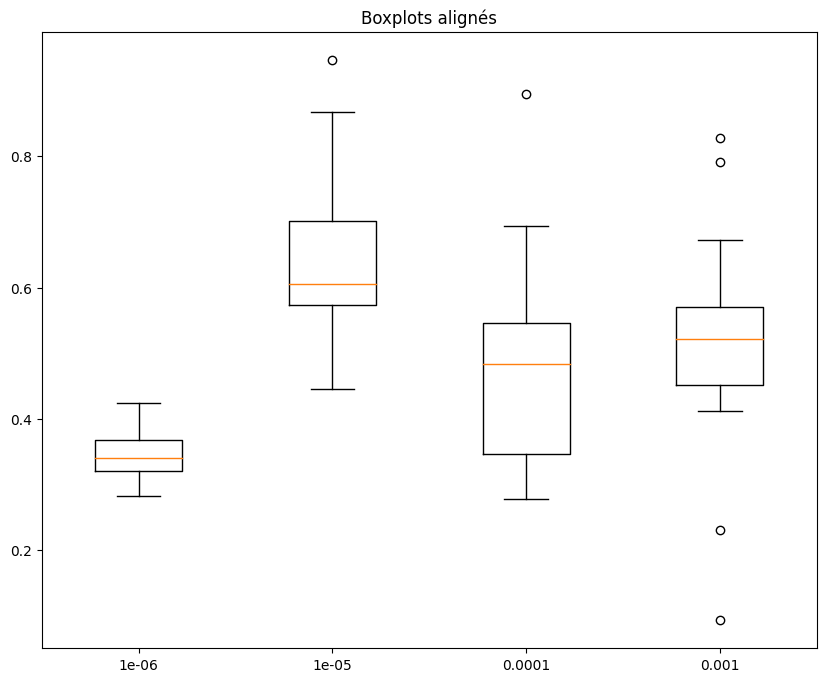

In [15]:

beta = [10**(-6),10**(-5),10**(-4),10**(-3)]
prices = pr.PriceOptimizer()
prices_binary = pr.PriceOptimizer(binary_demand=True)
collusion_profit, collusion_prices = prices.CollusionPrice()
collusion_profit_binary, collusion_prices_binary = prices_binary.CollusionPrice()
nash_profit, nash_prices = prices.NashPrice()
nash_profit_binary, nash_prices_binary = prices_binary.NashPrice()

RN = nash_profit
RC = collusion_profit

    
Rmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0])))
DRmean = np.zeros((len(aggregated_agents), len(aggregated_agents[0]), len(aggregated_agents[0][0][0]))) 

# Parameters
n_params = len(aggregated_agents)

# Loop through each parameter  
for param_ind in range(n_params):

  # Loop through each sample
  for sample_ind in range(len(aggregated_agents[0])):
    for j in range (2):
      Rmean[param_ind][sample_ind][j] = aggregated_agents[param_ind][sample_ind][-100:,j].mean()
      DRmean[param_ind][sample_ind][j] = (Rmean[param_ind][sample_ind][j] - RN)/(RC - RN) 
      box = DRmean.mean(axis = 2)
# Mettre les données dans une liste
data = [box[param_ind] for param_ind in range(len(aggregated_agents))]
print(box[param_ind])

fig, ax = plt.subplots(figsize=(10, 8))

# Tracer les boxplots
ax.boxplot(data, 
           notch=False, 
           positions=[1,2,3,4]) 

# Personnaliser les axes
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(beta)

# Ajouter un titre
plt.title('Boxplots alignés')

plt.show()